In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm 
import pandas as pd

import matplotlib.pyplot as plt

In [233]:
from datetime import date

## Data

In [234]:
## , 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU'

In [235]:
assets = ['SPY']

In [236]:
train_X_ls = []
train_y_ls = []
valid_X_ls = []
valid_y_ls = []
test_X_ls = []
test_y_ls = []

#데이터 로딩
for ass in assets:
    train_X_ls.append(np.load(f'data/modeling/{ass}_train_X.npy'))
    train_y_ls.append(np.load(f'data/modeling/{ass}_train_y.npy'))
    valid_X_ls.append(np.load(f'data/modeling/{ass}_valid_X.npy'))
    valid_y_ls.append(np.load(f'data/modeling/{ass}_valid_y.npy'))
    test_X_ls.append(np.load(f'data/modeling/{ass}_test_X.npy'))
    test_y_ls.append(np.load(f'data/modeling/{ass}_test_y.npy'))

## 모든자산군에 날짜는 같지만..
train_ans_ls = []
valid_ans_ls = []
test_ans_ls = []
for ass in assets:    
    train_ans_ls.append(pd.read_csv(f'data/modeling/{ass}_train_ans.csv', index_col=0))
    valid_ans_ls.append(pd.read_csv(f'data/modeling/{ass}_valid_ans.csv', index_col=0))
    test_ans_ls.append(pd.read_csv(f'data/modeling/{ass}_test_ans.csv', index_col=0))

## Model

In [237]:
# EGRU 모델
class scorer(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel1, kernel2):
        super(scorer, self).__init__()
        self.hidden_dim = hidden_dim
        # 인코더
        self.encoder = nn.Conv2d(1, 1, kernel_size=(kernel1, kernel2))
        
        self.rnn1 = nn.GRU(input_dim - kernel2 + 1, hidden_dim, bidirectional=False)
        # 층이 깊으면 학습이 안돼서 제외
        ## self.rnn2 = nn.GRU(hidden_dim, hidden_dim + int(hidden_dim/2), bidirectional=False)
        ## self.rnn3 = nn.GRU(int(hidden_dim/2), int(hidden_dim/4), bidirectional=False)
        self.dl1 = nn.Dropout(p=.5)
        self.l1 = nn.Linear(hidden_dim, hidden_dim + int(hidden_dim/2))
        self.rel = nn.LeakyReLU()
        ## self.dl2 = nn.Dropout(p=.5)
        self.l2 = nn.Linear(hidden_dim + int(hidden_dim/2), hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        enc = self.encoder(x)
        enc = enc.reshape(enc.shape[0], enc.shape[2], enc.shape[3])
        
        enc = enc.permute(1, 0, 2)
        ## enc = self.encoder(x)
        ## dec = self.decoder(enc)
        
        out, _ = self.rnn1(enc)
        ## out,_ = self.rnn2(out)
        ## out,_ = self.rnn3(out)

        mr = out[-1]
        out = self.l1(mr)
        out = self.dl1(out)
        out = self.rel(out)
        ## out = self.dl2(out)
        out = self.l2(out)
        out = self.l3(out)

        return out.flatten()

In [238]:
'''# EGRU 모델
class scorer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(scorer, self).__init__()
        self.hidden_dim = hidden_dim
        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim/2)),
            nn.LeakyReLU(),
            nn.Linear(int(input_dim/2), int(input_dim/2)))
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim/2), int(input_dim/2)),
            nn.LeakyReLU(),
            nn.Linear(int(input_dim/2), input_dim))

        self.rnn1 = nn.GRU(input_dim, hidden_dim, bidirectional=False)
        # 층이 깊으면 학습이 안돼서 제외
        ## self.rnn2 = nn.GRU(hidden_dim, hidden_dim + int(hidden_dim/2), bidirectional=False)
        ## self.rnn3 = nn.GRU(int(hidden_dim/2), int(hidden_dim/4), bidirectional=False)
        self.dl1 = nn.Dropout(p=.5)
        self.l1 = nn.Linear(hidden_dim, hidden_dim + int(hidden_dim/2))
        self.rel = nn.LeakyReLU()
        ## self.dl2 = nn.Dropout(p=.5)
        self.l2 = nn.Linear(hidden_dim + int(hidden_dim/2), hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        ## enc = self.encoder(x)
        ## dec = self.decoder(enc)
        
        out, _ = self.rnn1(x)
        ## out,_ = self.rnn2(out)
        ## out,_ = self.rnn3(out)

        mr = out[-1]
        out = self.l1(mr)
        out = self.dl1(out)
        out = self.rel(out)
        ## out = self.dl2(out)
        out = self.l2(out)
        out = self.l3(out)

        return out.flatten()'''

'# EGRU 모델\nclass scorer(nn.Module):\n    def __init__(self, input_dim, hidden_dim):\n        super(scorer, self).__init__()\n        self.hidden_dim = hidden_dim\n        # 인코더\n        self.encoder = nn.Sequential(\n            nn.Linear(input_dim, int(input_dim/2)),\n            nn.LeakyReLU(),\n            nn.Linear(int(input_dim/2), int(input_dim/2)))\n        # 디코더\n        self.decoder = nn.Sequential(\n            nn.Linear(int(input_dim/2), int(input_dim/2)),\n            nn.LeakyReLU(),\n            nn.Linear(int(input_dim/2), input_dim))\n\n        self.rnn1 = nn.GRU(input_dim, hidden_dim, bidirectional=False)\n        # 층이 깊으면 학습이 안돼서 제외\n        ## self.rnn2 = nn.GRU(hidden_dim, hidden_dim + int(hidden_dim/2), bidirectional=False)\n        ## self.rnn3 = nn.GRU(int(hidden_dim/2), int(hidden_dim/4), bidirectional=False)\n        self.dl1 = nn.Dropout(p=.5)\n        self.l1 = nn.Linear(hidden_dim, hidden_dim + int(hidden_dim/2))\n        self.rel = nn.LeakyReLU()\n        ##

In [239]:
#데이터 클래스 정의
class Dataset(Dataset):
    def __init__(self, X, y):

        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __getitem__(self, i):
        return (self.X[i], self.y[i])

    def __len__(self):
        return (len(self.y))

In [278]:
#훈련 하이퍼 파라미터
batch_size = 4
lr = .001
num_epoch = 10
log_interval = 10
loss_fn = nn.MSELoss()
model_name = 'scoring.pth'
sc_hidden_dim = 2500
wei_dec = 0.00001

kernel1 = train_X_ls[0].shape[1]//8 ## 시계열 커널
kernel2 = train_X_ls[0].shape[2]//2 ## 설명변수 커널

In [279]:
trainloss_ls = []
validloss_ls = []
testloss_ls = []
ans_ls = []
hat_ls = []

for i in  range(len(assets)):
    print(f"{assets[i]} 시작!!")
    #GRU모델
    model = scorer(train_X_ls[i].shape[2], sc_hidden_dim, kernel1, kernel2).cuda()
    ## optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay = wei_dec)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0) ## lr 스케줄러

    ## Dataset
    traindataset = Dataset(train_X_ls[i],train_y_ls[i])
    validataset = Dataset(valid_X_ls[i],valid_y_ls[i])
    testdataset = Dataset(test_X_ls[i],test_y_ls[i])
    train_dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size)
    valid_dataloader = torch.utils.data.DataLoader(validataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size)


    print("Train 시작!")
    trl = []
    vll = []
    #training scheme
    for i in range(num_epoch):
        train_loss = 0
        valid_loss = 0
        model.train()
        #### Training
        for batch_id, (X,y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            out = model(X.cuda())

            loss = loss_fn(out,y.cuda())

            loss.backward()
            optimizer.step()

            lossavg = (loss/len(y)).data.cpu().numpy()
            train_loss += lossavg

            if batch_id % log_interval == 0:
                print('Epoch: ',i+1,' Batch ID: ',batch_id,' Train Loss: ',train_loss / (batch_id+1))
            trl.append(train_loss / (batch_id+1))
        scheduler.step()


        #### Evaluation on Validset
        model.eval()
        for batch_id, (X,y) in enumerate(valid_dataloader):
            out = model(X.cuda())

            loss = loss_fn(out,y.cuda())

            lossavg = (loss/len(y)).data.cpu().numpy()
            valid_loss += lossavg
        print('epoch: ',i+1,' Valid Loss: ',valid_loss / (batch_id+1))
        if len(vll) > 0:
            if max(vll) < valid_loss.item():
                torch.save(model.state_dict(),model_name)
        else:
            torch.save(model.state_dict(),model_name)
        vll.append((valid_loss/ (batch_id+1)))
        
    trainloss_ls.append(trl)
    validloss_ls.append(vll)

    ## Best Model
    model.load_state_dict(torch.load(model_name))

    print("Test 시작!")
    outs = []
    ys = []
    
    model.eval()
    ## trainset
    for batch_id, (X,y) in enumerate(train_dataloader):
        out = model(X.cuda())
        outs += out.tolist()
        ys += y.tolist()
    ## validset
    for batch_id, (X,y) in enumerate(valid_dataloader):
        out = model(X.cuda())
        outs += out.tolist()
        ys += y.tolist()
    ## testset
    test_loss=0
    for batch_id, (X,y) in enumerate(test_dataloader):
        out = model(X.cuda())
        loss = loss_fn(out,y.cuda())
        lossavg = (loss/len(y)).data.cpu().numpy()
        test_loss += lossavg
        outs += out.tolist()
        ys += y.tolist()
        
    print('Test Loss: ',test_loss / (batch_id+1))
    testloss_ls.append(test_loss)
    hat_ls.append(outs) 
    ans_ls.append(ys)

SPY 시작!!
Train 시작!
Epoch:  1  Batch ID:  0  Train Loss:  0.0001242601138073951
Epoch:  1  Batch ID:  10  Train Loss:  0.032083583101418546
Epoch:  1  Batch ID:  20  Train Loss:  0.019048746140296793
epoch:  1  Valid Loss:  0.0019374103079220124
Epoch:  2  Batch ID:  0  Train Loss:  0.001373618608340621
Epoch:  2  Batch ID:  10  Train Loss:  0.0008436285451435568
Epoch:  2  Batch ID:  20  Train Loss:  0.0010664862839760082
epoch:  2  Valid Loss:  0.0006431669268446664
Epoch:  3  Batch ID:  0  Train Loss:  0.00044799837633036077
Epoch:  3  Batch ID:  10  Train Loss:  0.0007323715597687459
Epoch:  3  Batch ID:  20  Train Loss:  0.0008105604082673034
epoch:  3  Valid Loss:  0.0008331802261333602
Epoch:  4  Batch ID:  0  Train Loss:  0.000639400677755475
Epoch:  4  Batch ID:  10  Train Loss:  0.0004944297556490214
Epoch:  4  Batch ID:  20  Train Loss:  0.0006539818915327833
epoch:  4  Valid Loss:  0.0005538802514214088
Epoch:  5  Batch ID:  0  Train Loss:  0.00015044219617266208
Epoch:  5  

In [280]:
optimizer.param_groups[0]['lr']

0.0005

SPY
Train loss


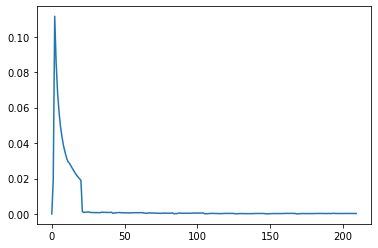

Validation loss


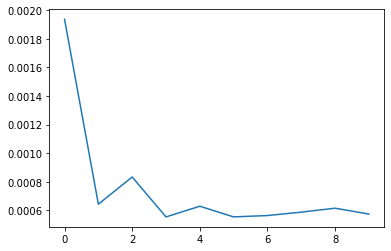

Test loss: 0.0034
--------------------------------------------------------


In [281]:
for i in range(len(assets)):
    print(assets[i])
    print('Train loss')
    plt.plot(trainloss_ls[i])
    plt.show()
    print('Validation loss')
    plt.plot(validloss_ls[i])
    plt.show()
    print(f'Test loss: {testloss_ls[i].round(4)}')
    print('--------------------------------------------------------')

SPY
validation


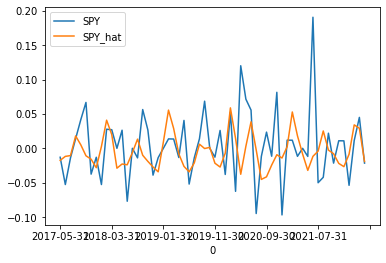

test


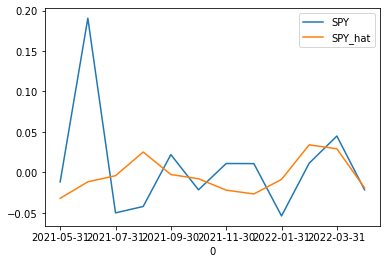

In [282]:
score_ls = []
for i in range(len(assets)): 
    print(assets[i])
    df_answer = pd.concat([train_ans_ls[i], valid_ans_ls[i], test_ans_ls[i]])
    df_answer[assets[i]] = ans_ls[i]
    df_answer[assets[i]+'_hat'] = hat_ls[i]
    print("validation")
    df_answer.set_index('0')['2017-05-31':].plot()
    plt.show()
    print("test")
    df_answer.set_index('0')['2021-05-31':].plot()
    score_ls.append(df_answer.set_index('0'))
    plt.show()

In [283]:
result_df = pd.concat(score_ls, axis=1)

In [284]:
test = result_df['2021-05-31':].copy()

In [285]:
test['ans'] = test['SPY']>=0
test['pred'] = test['SPY_hat']>=0

In [286]:
(test['ans'] == test['pred']).sum()/len(test)

0.5833333333333334

In [420]:
date_idx = date.today().strftime('%Y-%m-%d')
result_df.to_csv(f'data/result_{date_idx}.csv')